# **SVHN Dataset**
In the following exercices, you will work with the SVHN dataset: http://ufldl.stanford.edu/housenumbers/

It contains RGB images of street digits labeled from 1 to 10 similar to the MNIST dataset.

The train and test sets are provided in the folder Data/svhn/ in .mat format.
In the following we show an example of how to load the images and labels from these files. A DataLoader for this dataset is provided in the code examples for the lab.

In [ ]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
import MyTorchWrapper as mtw

: 

In [2]:
# from google.colab import drive
# # Mount Google Drive
# drive.mount('/content/drive')
# %cd "/content/drive/DeepLearning/P3/"

## Global variables

In [2]:
data_path = 'Data/'
results_path = 'Results/'
save_figure = True # Whether to save figures or not
device = mtw.get_torch_device(use_gpu=True, debug=True)
torch.manual_seed(10)

Device selected: mps


## Useful plotting functions

In [4]:
def plot_acc_loss(fig, axes, accuracies, losses, epochs, save_figure, plot_mode="both"):
    if plot_mode != "both" and plot_mode != "smooth" and plot_mode != "real":
        print("plot_mode options: both, smooth or both")
        return
    
    window = 100
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    
    
    epoch_range = np.arange(epochs + 1)
    
    if plot_mode != "smooth":
        axes[0].plot(accuracies, label="Real accuracies", color="#68CDFF")
    
    if plot_mode != "real":
        smoothed_accuracies = scipy.signal.savgol_filter(accuracies, window, 5)
        axes[0].plot(smoothed_accuracies, label="Smoothed accuracies", color="blue")
    
    axes[0].set_xlim(None)
    # axes[0].set_xticks(epoch_range * len(losses), epoch_range)
    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Steps (number of forward passes)")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].set_ylim((0, 100))
    axes[0].legend()
    axes[0].grid()

    if plot_mode != "smooth":
        axes[1].plot(losses, label="Real losses", color="#68CDFF")
    
    if plot_mode != "real":
        smoothed_losses = scipy.signal.savgol_filter(losses, window, 5)
        axes[1].plot(smoothed_losses, label="Smoothed losses", color="blue")
    
    axes[1].set_title("Loss at each step")
    axes[1].set_xlabel("Steps (number of forward passes)")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, None))
    axes[1].legend()
    axes[1].grid()

    return fig

## IOManager

Set up an IOManager to handle the process of saving and loading model checkpoints.  

In [3]:
iomanager = mtw.IOManager(storage_dir=results_path + 'notebook_models/')

# Ex. 1

1. Try to obtain the maximum test accuracy possible in the SVHN dataset. For this purpose train/test different variants of the CNN provided in P3-Part1-Examples. You can explore different strategies:

    - 1.1. Increase the size of the network by adding one ore more conv. layers. You can also increase the number of filters in each layer.
    
    - 1.2. Try different optimizers such as Adam or SGD with momentum and modify the learning rate. You can check: https://pytorch.org/docs/stable/optim.html
    
    - 1.3. Explore different random transformations during training (Data augmentation) such as random cropping with padding. You can check: https://pytorch.org/docs/stable/torchvision/transforms.html. Remember that these random transofrmations must not be used during testing.
    
    - 1.4 Whatever you consider...

2. Save all the different models, compare their test accuracy and analyse the results. Discuss what model has been shown more effective and why have you used the different strategies.

## Define the dataset class

In [7]:
class SVHN(torch.utils.data.Dataset):
    # Initialization method for the dataset
    def __init__(self,dataDir = data_path+'/svhn/train_32x32.mat',transform = None):
        mat_loaded = sio.loadmat(dataDir)
        self.data = mat_loaded['X']
        self.labels = mat_loaded['y'].squeeze()
        self.labels -= self.labels.min()
        self.transform = transform
     # What to do to load a single item in the dataset ( read image and label)    
    def __getitem__(self, index):
        data = self.data[:,:,:,index]
        lbl = self.labels[index]
        
        data = Image.fromarray(data)
        # Apply a trasnformaiton to the image if it is indicated in the initalizer
        if self.transform is not None : 
            data = self.transform(data)
        
        # return the image and the label
        return data,lbl
    
    
    # Return the number of images
    def __len__(self):
        return self.data.shape[3]

## Define the Neural Network model class

In [7]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5,  padding=2)
        #input : 1 channel, output 16 channel, filter size : 5x5
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3,  padding=1)
        #input : 1 channel, output 16 channel, filter size : 3x3
        
        self.fc = nn.Linear(8 * 8 * 32, num_classes)
        
        self.maxpool= nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        
        out = out.reshape(out.size(0), -1) #128,32,7,7 -> 128,7*7*32
        out = self.fc(out) # we don't need sigmoid or other activation function at the end beacuse we will use nn.CrossEntropyLoss() (check documentation to understand why)
        return out 

## Load the training and testing data

In [8]:
"""
Load data 
"""
tr = transforms.Compose([
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat', tr)
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)

train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain, batch_size=256, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest, batch_size=256, pin_memory=True)

## Define initial hyperparameters

In [9]:
num_epochs = 5
learning_rate = .001
# optimizer = torch.optim.SGD(CNN.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.9)
evaluation = mtw.AccuracyEvaluation(loss_criterion=nn.CrossEntropyLoss())

## Training the model: initial results

Training model 1 with 73257 images...
Epoch [1/5], Step [97/287], Loss: 1.0224
Epoch [1/5], Step [194/287], Loss: 0.9213
Epoch [1/5], Step [287/287], Loss: 0.6135
Epoch [2/5], Step [97/287], Loss: 0.5490
Epoch [2/5], Step [194/287], Loss: 0.4854
Epoch [2/5], Step [287/287], Loss: 1.6123
Epoch [3/5], Step [97/287], Loss: 0.3970
Epoch [3/5], Step [194/287], Loss: 0.3719
Epoch [3/5], Step [287/287], Loss: 0.4565
Epoch [4/5], Step [97/287], Loss: 0.3438
Epoch [4/5], Step [194/287], Loss: 0.5970
Epoch [4/5], Step [287/287], Loss: 0.4289
Epoch [5/5], Step [97/287], Loss: 0.3664
Epoch [5/5], Step [194/287], Loss: 0.4424
Epoch [5/5], Step [287/287], Loss: 0.5430


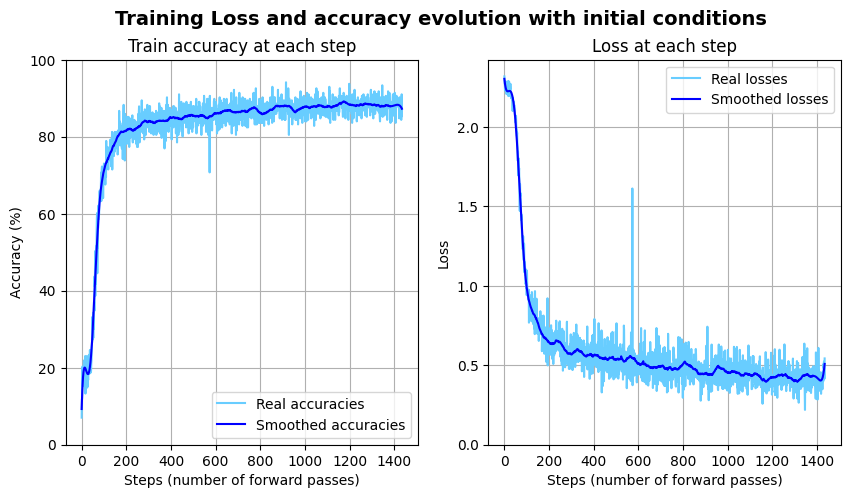

In [10]:
model_id = iomanager.next_id_available()
print(f"Training model {model_id} with {len(SVHNTrain)} images...")

# Create an instance of the model
CNN = ConvNet() 
optimizer = torch.optim.Adam(CNN.parameters(), lr=learning_rate)

# Train the model
trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=train_loader, device=device)
train_results = trainer.train(CNN, optimizer, verbose=True)
initial_train_losses = train_results['loss']
initial_train_accuracies = train_results['accuracy']

# Plot loss and accuracy evolution with the training dataset
fig2, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Training Loss and accuracy evolution with initial conditions", fontsize=14, fontweight="bold")
plot_acc_loss(fig2, axes, initial_train_accuracies, initial_train_losses, num_epochs, save_figure, plot_mode="both")
if save_figure:
    plt.savefig(f"{results_path}/fig2.png", dpi=300)
plt.show()

# Save the model checkpoint
iomanager.save(model=CNN, model_id=model_id)

## Testing the model: initial results

In [11]:
# Test the model with the test dataset
tester = mtw.Tester(evaluation=evaluation, data_loader=test_loader, device=device)
test_results = tester.test(CNN)
initial_test_acc = test_results["accuracy"]
print(f'Test Accuracy of the model on the {len(SVHNTest)} test images: {initial_test_acc} %')

# Save a model summary
summary = mtw.training_summary(CNN, optimizer, trainer, test_results)
iomanager.save_summary(summary_content=summary, model_id=model_id)

# Compute model paramters
print("Number of parameters of the model:", mtw.get_model_params(CNN))

Test Accuracy of the model on the 26032 test images: 86.22080516287646 %
Number of parameters of the model: 26346


## Trying different learning rates ($\alpha$)

In [12]:
learning_rates = [0.1, 0.01, 0.005, 0.001, 0.0001]
lr_accuracies = {}
lr_losses = {}


for lr in learning_rates:
    model_id = iomanager.next_id_available()
    print(f"\nTraining model {model_id} with learning_rate = {lr}...")

    # Adjust optimizer with new learning rate
    model = ConvNet()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train the model
    train_results = trainer.train(model, optimizer, verbose=False)
    lr_losses[lr] = train_results['loss']
    lr_accuracies[lr] = train_results['accuracy']

    # Save the model checkpoint
    iomanager.save(model=model, model_id=model_id)

    # Test the model with the test dataset
    test_results = tester.test(model)
    test_accuracy = test_results["accuracy"]
    print(f'Test Accuracy of model {model_id} on the {len(SVHNTest)} test images: {test_accuracy} %')

    # Save a model summary
    summary = mtw.training_summary(model, optimizer, trainer, test_results)
    iomanager.save_summary(summary_content=summary, model_id=model_id)


Training model 2 with learning_rate = 0.1...
Test Accuracy of model 2 on the 26032 test images: 19.587430854333128 %

Training model 3 with learning_rate = 0.01...
Test Accuracy of model 3 on the 26032 test images: 68.43884449907806 %

Training model 4 with learning_rate = 0.005...
Test Accuracy of model 4 on the 26032 test images: 81.25768285187462 %

Training model 5 with learning_rate = 0.001...
Test Accuracy of model 5 on the 26032 test images: 86.11324523663184 %

Training model 6 with learning_rate = 0.0001...
Test Accuracy of model 6 on the 26032 test images: 77.50460971112477 %


## Plot learning rate exploration results

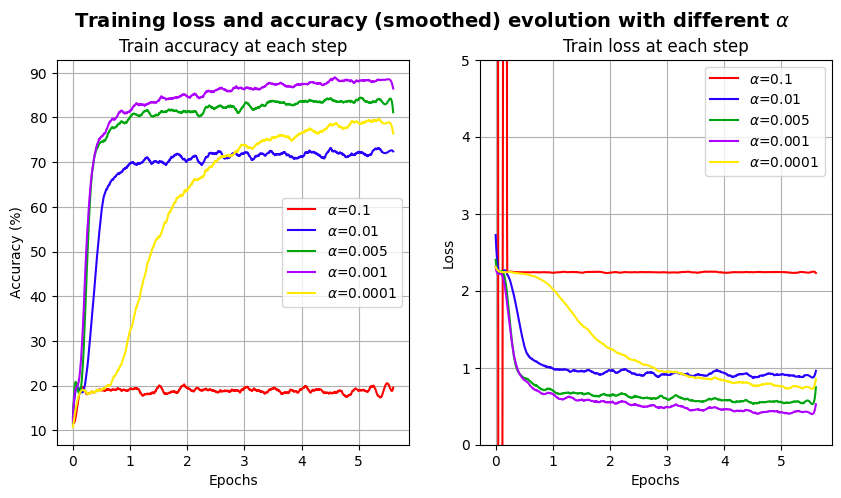

In [13]:
colors = ["#ff0000", "#2700ff", "#00A610", "#af00ff", "#FFEA00"]
lighter_colors = ["#FF5E5E", "#9784FF", "#57A65F", "#DB8CFF", "#FFF47B"]


ncols = 2
fig3, axes = plt.subplots(1, ncols, figsize=(10, 5))
plt.suptitle("Training loss and accuracy (smoothed) evolution with different $\\alpha$", fontsize=14, fontweight="bold")
for i, lr in enumerate(learning_rates):
    acc = lr_accuracies[lr]
    loss = lr_losses[lr]
    window = 100
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    for col in range(ncols):
        if col == 0:
            val = acc
        elif col == 1:
            val = loss
        epoch_range = np.arange(num_epochs + 1)
        # axes[col].plot(val, label="Real accuracies", color=lighter_colors[i])
        smoothed = scipy.signal.savgol_filter(val, window, 5)
        axes[col].plot(smoothed, label=f"$\\alpha$={lr}", color=colors[i])
        axes[col].set_xlim(None)
        axes[col].set_xticks(epoch_range * 256, epoch_range)
        axes[col].legend()
        axes[col].grid()

    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[1].set_title("Train loss at each step")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, 5))

if save_figure: plt.savefig(f"{results_path}/fig3.png", dpi=300)
plt.show()

## Trying different batch sizes

In [14]:
batch_sizes = [16, 32, 64, 128, 256, 512]
batch_accuracies = {}
batch_losses = {}


for batch in batch_sizes:
    model_id = iomanager.next_id_available()
    print(f"\nTraining model {model_id} with batch size = {batch}...")

    # Change the batch size
    model = ConvNet()
    train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain, batch_size=batch, shuffle=True, pin_memory=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Best lr from the previous step

    # Train the model
    trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=train_loader, device=device)
    train_results = trainer.train(model, optimizer, verbose=False)
    batch_losses[batch] = train_results['loss']
    batch_accuracies[batch] = train_results['accuracy']

    # Save the model checkpoint
    iomanager.save(model=model, model_id=model_id)

    # Test the model with the test dataset
    test_results = tester.test(model)
    test_accuracy = test_results["accuracy"]
    print(f'Test Accuracy of model {model_id} on the {len(SVHNTest)} test images: {test_accuracy} %')

    # Save a model summary
    summary = mtw.training_summary(model, optimizer, trainer, test_results)
    iomanager.save_summary(summary_content=summary, model_id=model_id)


Training model 7 with batch size = 16...
Test Accuracy of model 7 on the 26032 test images: 86.93531038721574 %

Training model 8 with batch size = 32...
Test Accuracy of model 8 on the 26032 test images: 86.35525507068223 %

Training model 9 with batch size = 64...
Test Accuracy of model 9 on the 26032 test images: 87.0582360172096 %

Training model 10 with batch size = 128...
Test Accuracy of model 10 on the 26032 test images: 86.79701905347265 %

Training model 11 with batch size = 256...
Test Accuracy of model 11 on the 26032 test images: 86.42055931161647 %

Training model 12 with batch size = 512...
Test Accuracy of model 12 on the 26032 test images: 84.84941610325752 %


## Plot batch size exploration results

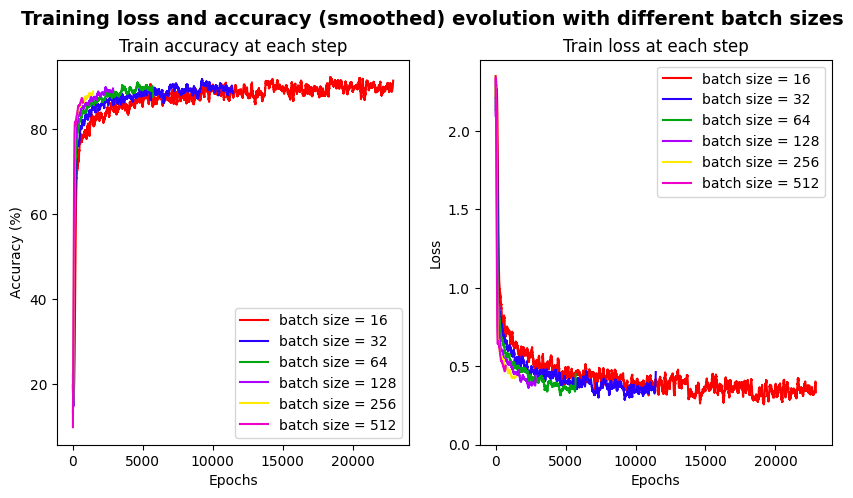

In [15]:
colors = ["#ff0000", "#2700ff", "#00A610", "#af00ff", "#FFEA00", "#EE00CB"]
lighter_colors = ["#FF5E5E", "#9784FF", "#57A65F", "#DB8CFF", "#FFF47B", "#EE60D9"]

ncols = 2
fig4, axes = plt.subplots(1, ncols, figsize=(10, 5))
plt.suptitle("Training loss and accuracy (smoothed) evolution with different batch sizes", fontsize=14, fontweight="bold")
for i, batch in enumerate(batch_sizes):
    acc = batch_accuracies[batch]
    loss = batch_losses[batch]
    window = 300
    # smoothed_accuracies = np.convolve(train_accuracies, np.ones(window)[::-1], mode="same")

    for col in range(ncols):
        if col == 0:
            val = acc
        elif col == 1:
            val = loss
        epoch_range = np.arange(num_epochs + 1)
        # axes[col].plot(val, label="Real accuracies", color=lighter_colors[i])
        smoothed = scipy.signal.savgol_filter(val, window, 5)
        axes[col].plot(smoothed, label=f"batch size = {batch}", color=colors[i])
        axes[col].set_xlim(None)
        # axes[col].set_xticks(epoch_range * batch_sizes[-1], epoch_range)
        axes[col].legend()
        axes[col].grid()
    

    axes[0].set_title("Train accuracy at each step")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[1].set_title("Train loss at each step")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].set_ylim((0, None))


if save_figure: plt.savefig(f"{results_path}/fig4.png", dpi=300)
plt.show()

## Visualize the effect of some transformations

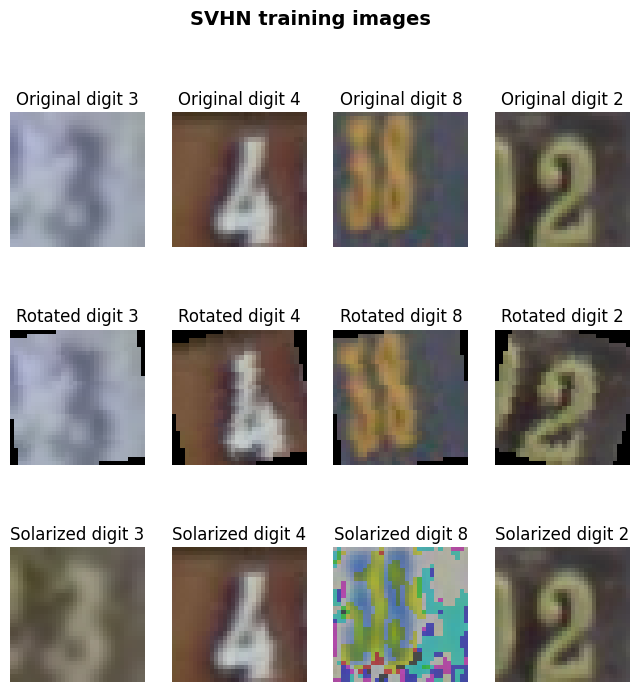

In [16]:
tr_plot = transforms.Compose([
        transforms.ToTensor(),
        ])

SVHNTrain_plot = SVHN(data_path+'/svhn/train_32x32.mat', tr_plot)


# network 
train_loader_plot = torch.utils.data.DataLoader(dataset=SVHNTrain_plot, batch_size=1, shuffle=True)

num_images = 4
num_rows = 3

fig5, axes = plt.subplots(num_rows, num_images, figsize=(8, 8))
fig5.suptitle("SVHN training images", fontsize=14, fontweight="bold")
row = 0

original_images = []
rotated_images = []
solarized_images = []
count = 0
rotator = transforms.RandomRotation(degrees=(-25, 25))
solarize = transforms.RandomSolarize(threshold=0.3, p=0.8)
plotted_labels = []

for images, labels in train_loader_plot:
    plotted_labels.append(labels.item() + 1)
    original_images.append(images)
    rotated_images.append(rotator(images))
    solarized_images.append(solarize(images))
    count += 1
    if count >= 4: break



# axes[0].set_title("Original images")
for col, image in enumerate(original_images):
    axes[0, col].axis("off")
    axes[0, col].imshow(original_images[col][0].permute(1, 2, 0))
    axes[0, col].set_title(f"Original digit {plotted_labels[col]}")

for col, image in enumerate(original_images):
    axes[1, col].axis("off")
    axes[1, col].imshow(rotated_images[col][0].permute(1, 2, 0))
    axes[1, col].set_title(f"Rotated digit {plotted_labels[col]}")

for col, image in enumerate(original_images):
    axes[2, col].axis("off")
    axes[2, col].imshow(solarized_images[col][0].permute(1, 2, 0))
    axes[2, col].set_title(f"Solarized digit {plotted_labels[col]}")

# if save_figure: plt.savefig(f"{results_path}/fig5.png", dpi=300)
plt.show()
    

## Check how image transformations affect training

Load data and define hyperparameters

In [17]:
tr = transforms.Compose([
        transforms.RandomRotation(degrees=(-25, 25)),
        transforms.RandomSolarize(threshold=0.3, p=0.8),
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

SVHNTrain = SVHN(data_path+'/svhn/train_32x32.mat', tr)
transofrmed_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain, batch_size=256, shuffle=True)

model = ConvNet()
num_epochs = 5
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model


Training model 13 (with image transformations)...
Epoch [1/5], Step [49/144], Loss: 1.9231
Epoch [1/5], Step [98/144], Loss: 0.8531
Epoch [1/5], Step [144/144], Loss: 0.6293
Epoch [2/5], Step [49/144], Loss: 0.6333
Epoch [2/5], Step [98/144], Loss: 0.6438
Epoch [2/5], Step [144/144], Loss: 1.5979
Epoch [3/5], Step [49/144], Loss: 0.4673
Epoch [3/5], Step [98/144], Loss: 0.5072
Epoch [3/5], Step [144/144], Loss: 0.5564
Epoch [4/5], Step [49/144], Loss: 0.4707
Epoch [4/5], Step [98/144], Loss: 0.4808
Epoch [4/5], Step [144/144], Loss: 0.5046
Epoch [5/5], Step [49/144], Loss: 0.5167
Epoch [5/5], Step [98/144], Loss: 0.6299
Epoch [5/5], Step [144/144], Loss: 0.7160


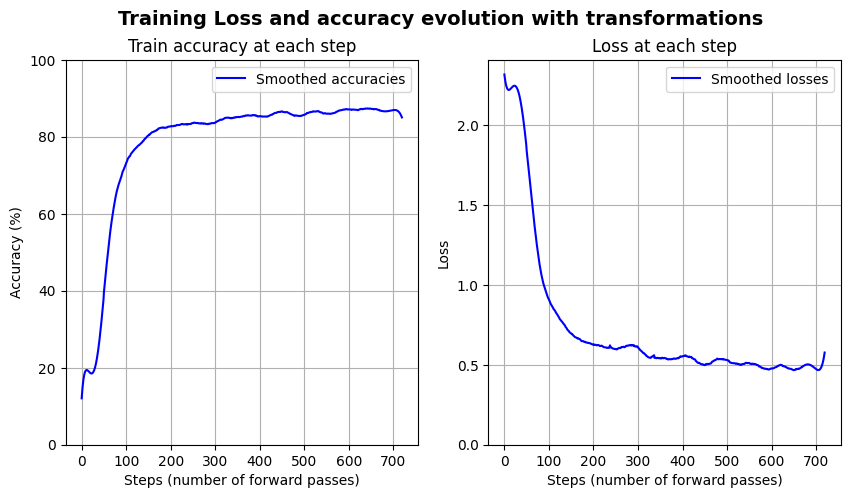

In [18]:
model_id = iomanager.next_id_available()
print(f"\nTraining model {model_id} (with image transformations)...")

# Train the model
trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=train_loader, device=device)
train_results = trainer.train(model, optimizer, verbose=True)
train_losses = train_results['loss']
train_accuracies = train_results['accuracy']

# Save the model checkpoint
iomanager.save(model=model, model_id=model_id)

# Plot the results
fig6, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Training Loss and accuracy evolution with transformations", fontsize=14, fontweight="bold")
plot_acc_loss(fig6, axes, train_accuracies, train_losses, num_epochs, save_figure, plot_mode="smooth")
if save_figure: plt.savefig(f"{results_path}/fig6.png", dpi=300)
plt.show()

Test the model

In [19]:
# Test the model with the test dataset
test_results = tester.test(model)
test_accuracy = test_results["accuracy"]
print(f'Test Accuracy of model {model_id} on the {len(SVHNTest)} test images: {test_accuracy} %')

# Save a model summary
summary = mtw.training_summary(model, optimizer, trainer, test_results)
iomanager.save_summary(summary_content=summary, model_id=model_id)


Test Accuracy of model 13 on the 26032 test images: 84.74953902888753 %


## Training the Neural Network model with the extended dataset

Load the extended dataset and set the hyperparameters

In [20]:
tr = transforms.Compose([
        # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ToTensor(),
        transforms.Normalize(mean = [.5], std = [.5])
        ])

SVHNTrain_extended = SVHN(data_path+'/svhn/extra_32x32.mat', tr)
train_loader_extended = torch.utils.data.DataLoader(dataset=SVHNTrain_extended, batch_size=256, shuffle=True, pin_memory=True)

model = ConvNet()
learning_rate = .001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model with the extended dataset

In [21]:
model_id = iomanager.next_id_available()
print(f"\nTraining model {model_id} (with extended dataset)...")

# Train the model
trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=train_loader_extended, device=device)
train_results = trainer.train(model, optimizer, verbose=True)
train_losses_extended = train_results['loss']
train_accuracies_extended = train_results['accuracy']

# Save the model checkpoint
iomanager.save(model=model, model_id=model_id)


Training model 14 (with extended dataset)...
Epoch [1/5], Step [693/2075], Loss: 0.3309
Epoch [1/5], Step [1386/2075], Loss: 0.2228
Epoch [1/5], Step [2075/2075], Loss: 0.2092
Epoch [2/5], Step [693/2075], Loss: 0.2328
Epoch [2/5], Step [1386/2075], Loss: 0.1426
Epoch [2/5], Step [2075/2075], Loss: 0.3108
Epoch [3/5], Step [693/2075], Loss: 0.2177
Epoch [3/5], Step [1386/2075], Loss: 0.1674
Epoch [3/5], Step [2075/2075], Loss: 0.1466
Epoch [4/5], Step [693/2075], Loss: 0.1142
Epoch [4/5], Step [1386/2075], Loss: 0.1305
Epoch [4/5], Step [2075/2075], Loss: 0.2899
Epoch [5/5], Step [693/2075], Loss: 0.1340
Epoch [5/5], Step [1386/2075], Loss: 0.1068
Epoch [5/5], Step [2075/2075], Loss: 0.1524


Plot the results and compare them with the initial results

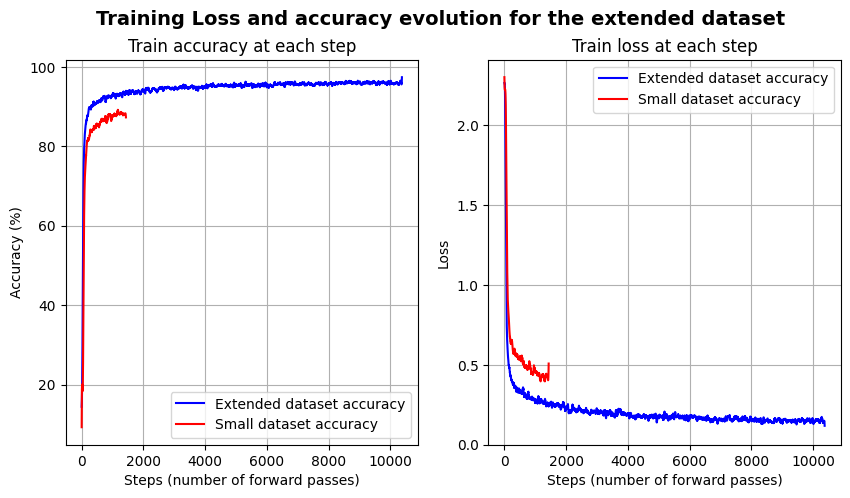

In [22]:
fig7, axes = plt.subplots(1, 2, figsize=(10, 5))
plt.suptitle("Training Loss and accuracy evolution for the extended dataset", fontsize=14, fontweight="bold")
# plot_acc_loss(fig7, axes, train_accuracies_extended, train_losses_extended, num_epochs, save_figure, plot_mode="smooth")

axes[0].plot(scipy.signal.savgol_filter(train_accuracies_extended, 100, 5), label="Extended dataset accuracy", color="blue")
axes[0].plot(scipy.signal.savgol_filter(initial_train_accuracies, 100, 5), label="Small dataset accuracy", color="red")

axes[1].plot(scipy.signal.savgol_filter(train_losses_extended, 100, 5), label="Extended dataset accuracy", color="blue")
axes[1].plot(scipy.signal.savgol_filter(initial_train_losses, 100, 5), label="Small dataset accuracy", color="red")

axes[0].set_title("Train accuracy at each step")
axes[0].set_xlabel("Steps (number of forward passes)")
axes[0].set_ylabel("Accuracy (%)")
axes[1].set_title("Train loss at each step")
axes[1].set_xlabel("Steps (number of forward passes)")
axes[1].set_ylabel("Loss")
axes[1].set_ylim((0, None))
axes[0].grid()
axes[1].grid()
axes[0].legend()
axes[1].legend()


if save_figure: plt.savefig(f"{results_path}/fig7.png", dpi=300)
plt.show()

Test the model

In [23]:
# Test the model with the test dataset
test_results = tester.test(model)
test_accuracy = test_results["accuracy"]
print(f'Test Accuracy of model {model_id} on the {len(SVHNTest)} test images: {test_accuracy} %')

# Save a model summary
summary = mtw.training_summary(model, optimizer, trainer, test_results)
iomanager.save_summary(summary_content=summary, model_id=model_id)

Test Accuracy of model 14 on the 26032 test images: 90.70374923171481 %


# Ex. 2

# **Building your own efficient Convolutional Network architecture for SVHN**

In the following,  you will need to build your own CNN architecture to predict digit numbers on the SVHN dataset. You are completely free to use any kind of layers and hyper-parameters for this purpose. Your goal is to acheive the maximum possible accuracy on the test set (the better, the higher score you'll get in the exercice). The only constraint is that **your model should not contain more than 150K parameters**. Below, we provide a simple code to compute the number of parameters in a model.

1. Design and implement your own CNN. Given that the number of parameters must be small, you can check some papers focused on efficient CNN architectures and get some ideas.

    - **MobileNet**: https://arxiv.org/abs/1704.04861

    - **MobileNet V2**: https://arxiv.org/pdf/1801.04381.pdf

    - **SqueezeNet**: https://arxiv.org/abs/1602.07360

    - **ShuffleNet**: https://arxiv.org/abs/1707.01083

    - **ESPNet V2**: https://arxiv.org/abs/1811.11431

2. Train it and test it on SVHN using the provided code.

3. Discuss what approaches have you tried, why, and which ones have shown to be more beneficial.

## Sol. 2

### Define your own model and check the number of total parameters

In [8]:
class MyModel(nn.Module):
    def __init__(self, num_classes=10):
        
        super(MyModel, self).__init__()

        ## Inception
        self.conv11 = nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0)
        self.conv12 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1, groups=3),
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0)
        )
        self.conv13 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=5, stride=1, padding=2, groups=3),
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0)
        )
        self.conv14 = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=7, stride=1, padding=3, groups=3),
            nn.Conv2d(3, 16, kernel_size=1, stride=1, padding=0)
        )
        self.norm1 = nn.BatchNorm2d(16)
                
        ## VGG 
        self.conv31 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=2, groups=64),
            nn.Conv2d(64, 128, kernel_size=1, stride=1, padding=0)
        )
        self.conv32 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=7, stride=1, padding=3, groups=128),
            nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
        )
        self.norm2 = nn.BatchNorm2d(128)


        self.conv41 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=5, stride=1, padding=2, groups=128),
            nn.Conv2d(128, 196, kernel_size=1, stride=1, padding=0)
        )
        self.conv42 = nn.Sequential(
            nn.Conv2d(196, 196, kernel_size=5, stride=1, padding=2, groups=196),
            nn.Conv2d(196, 196, kernel_size=1, stride=1, padding=0)
        )
        self.norm3 = nn.BatchNorm2d(256)
        
        self.dropout2d = nn.Dropout2d(p=0.05)
        self.dropout = nn.Dropout(p=0.05)
        self.fc = nn.Linear(1764, num_classes, bias=True)
        
        
        self.maxpool= nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        
        ## Inception
        #Inc 1 
        out1 = self.relu(self.conv11(x))
        out2 = self.relu(self.conv12(x))
        out3 = self.relu(self.conv13(x))
        out4 = self.relu(self.conv14(x))
        out = torch.cat([out1, out2, out3, out4],dim=1)
        
        out = self.maxpool(out)
        out = self.dropout2d(out)

        # VGG
        out = self.relu(self.conv31(out))
        out = self.relu(self.conv32(out)+out)
        out = self.maxpool(out)
        out = self.dropout2d(out)

        out = self.relu(self.conv41(out))
        out = self.relu(self.conv42(out)+out)
        out = self.maxpool(out)
        
        #print(out.shape)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        out = self.relu(out)
        
        return out


model = MyModel(num_classes=10)
n_params = mtw.get_model_params(model)
print(f"Number of parameters of MyModel: {n_params}")

Number of parameters of MyModel: 124180


### Train your model on SVHN
It is **not allowed to change training hyper-parameters** such as learning rate, batch size or number of epochs. You can only modify the architecture definition.

In [9]:
# Create train data loader
tr = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean = [.5], std = [.5])
        ])

# NOTE: We use the extra dataset of SVHN (extra_32x32.mat) to have more data for training.
# You can download it at: http://ufldl.stanford.edu/housenumbers/extra_32x32.mat
SVHNTrain = SVHN(data_path + '/svhn/extra_32x32.mat', tr)
SVHNTest = SVHN(data_path+'/svhn/test_32x32.mat', tr)

train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain, batch_size=256, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset=SVHNTest, batch_size=256, pin_memory=True)

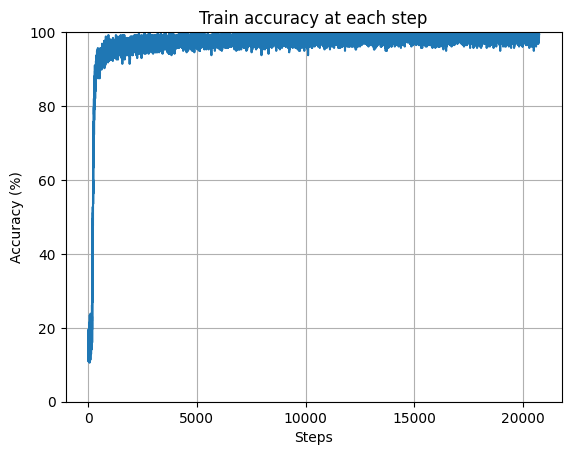

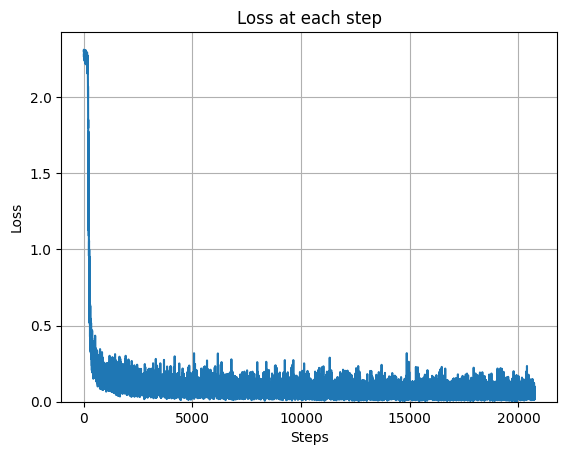

In [11]:
my_model = MyModel()
learning_rate = .1
num_epochs = 10
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate, weight_decay=1e-5, momentum=0.9)
evaluation = mtw.AccuracyEvaluation(loss_criterion=nn.CrossEntropyLoss())

model_id = iomanager.next_id_available()
print(f"Training model {model_id} (MyModel) with {len(SVHNTrain)} images...")

# Train the model
trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=train_loader, device=device)
train_results = trainer.train(my_model, optimizer, verbose=True)
train_losses = train_results['loss']
train_accuracies = train_results['accuracy']

# Plot training performance
fig8 = plt.figure(8)
plt.plot(train_accuracies)
plt.title("Train accuracy at each step")
plt.xlabel("Steps")
plt.ylabel("Accuracy (%)")
plt.ylim((0, 100))
plt.grid()
if save_figure: plt.savefig(f"{results_path}/fig8.png", dpi=300)
plt.show()

fig9 = plt.figure(9)
plt.plot(train_losses)
plt.title("Loss at each step")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.ylim((0, None))
plt.grid()
if save_figure: plt.savefig(f"{results_path}/fig9.png", dpi=300)
plt.show()

# Save the model checkpoint
iomanager.save(model=my_model, model_id=model_id)

### Test your model
As a reference, 93% of accuracy can be easily achieved by using only ~55000 parameters.

In [12]:
tester = mtw.Tester(evaluation=evaluation, data_loader=test_loader, device=device)
test_results = tester.test(my_model)
print(f'Test Accuracy of the model on the {len(SVHNTest)} test images: {test_results["accuracy"]} %')

# Save a model summary
summary = mtw.training_summary(my_model, optimizer, trainer, test_results)
iomanager.save_summary(summary_content=summary, model_id=model_id)

Test Accuracy of the model on the 26032 test images: 95.34035033804548 %


# Ex. 3

1. Use the implemented architecture in the previous exercice to solve the transfer learning task provided in the examples.

2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.

2. Report the test accuracy in each case and discuss the results. 

In [13]:
# TODO:

'\n1. Use the implemented architecture in the previous exercice to solve the transfer learning\n   task provided in the examples.\n2. Try to fine-tune not only the last layer for the CNN but a larger subset of parameters.\n2. Report the test accuracy in each case and discuss the results. \n'

## Sol. 3

### Initialize DataLoaders for Transfer Learning experiment

In [14]:
# Big dataset with numbers from 1 to 8
SVHNTrain_TL = SVHN(data_path+'/svhn_tl/tl_train_32x32.mat',tr)
tl_train_loader = torch.utils.data.DataLoader(dataset=SVHNTrain_TL, batch_size=256, shuffle=True, pin_memory=True)

# 200 samples of 0s and 9s
SVHNTrain_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_train_9_10_32x32.mat',tr)
tl_train_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTrain_TL_0_9, batch_size=64, shuffle=True, pin_memory=True)

# Test dataset with 0 and 9s
SVHNTest_TL_0_9 = SVHN(data_path+'/svhn_tl/tl_test_9_10_32x32.mat',tr)
tl_test_loader_0_9 = torch.utils.data.DataLoader(dataset=SVHNTest_TL_0_9, batch_size=64, shuffle=True)

### Pre-train your model with the big dataset with numbers from 1 to 8

In [15]:
# Use MyModel with just 8 classes
my_model_tl = MyModel(num_classes=8)

# Initialize optimizer 
learning_rate = .1
num_epochs = 10
optimizer = torch.optim.SGD(my_model_tl.parameters(),lr = learning_rate, weight_decay=1e-5, momentum=0.9)
evaluation = mtw.AccuracyEvaluation(loss_criterion=nn.CrossEntropyLoss())

# Train the model
model_id = iomanager.next_id_available()
print(f"Training model {model_id} (MyModel) with {len(SVHNTrain)} images...")

trainer = mtw.Trainer(evaluation=evaluation, epochs=num_epochs, data_loader=tl_train_loader, device=device)
train_results = trainer.train(my_model_tl, optimizer, verbose=True)
train_losses = train_results['loss']
train_accuracies = train_results['accuracy']


Training model 16 (MyModel) with 531131 images...
Epoch [1/10], Step [84/249], Loss: 2.0294
Epoch [1/10], Step [168/249], Loss: 2.0513
Epoch [1/10], Step [249/249], Loss: 1.9775
Epoch [2/10], Step [84/249], Loss: 1.8909
Epoch [2/10], Step [168/249], Loss: 1.0004
Epoch [2/10], Step [249/249], Loss: 0.5776
Epoch [3/10], Step [84/249], Loss: 0.4721
Epoch [3/10], Step [168/249], Loss: 0.3522
Epoch [3/10], Step [249/249], Loss: 0.2805
Epoch [4/10], Step [84/249], Loss: 0.4081
Epoch [4/10], Step [168/249], Loss: 0.2974
Epoch [4/10], Step [249/249], Loss: 0.3685
Epoch [5/10], Step [84/249], Loss: 0.2783
Epoch [5/10], Step [168/249], Loss: 0.3334
Epoch [5/10], Step [249/249], Loss: 0.2195
Epoch [6/10], Step [84/249], Loss: 0.2075
Epoch [6/10], Step [168/249], Loss: 0.2644
Epoch [6/10], Step [249/249], Loss: 0.2623
Epoch [7/10], Step [84/249], Loss: 0.2143
Epoch [7/10], Step [168/249], Loss: 0.1701
Epoch [7/10], Step [249/249], Loss: 0.3752
Epoch [8/10], Step [84/249], Loss: 0.2743
Epoch [8/10]

### Fine-tune the pretrained network with the small dataset of 9s and 0s

In [16]:
# TODO: 